# Various Models to Predict House Prices in King County, WA

In [1]:
# import the necessary libraries

import itertools
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
# loading dataframe
df=pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [92]:
# looking to see how recent the data is
df_date.sort_values(ascending=False)

16580   2015-05-27
13040   2015-05-24
5632    2015-05-15
12623   2015-05-14
19381   2015-05-14
           ...    
9587    2014-05-02
20543   2014-05-02
1040    2014-05-02
20586   2014-05-02
7316    2014-05-02
Name: date, Length: 21597, dtype: datetime64[ns]

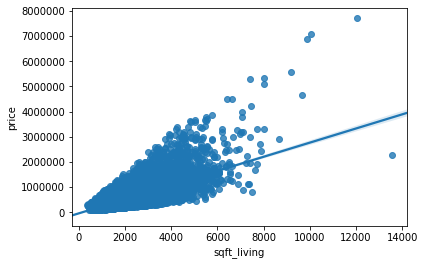

In [15]:
# regression plot of living space and price
sns.regplot(df['sqft_living'],df['price'])

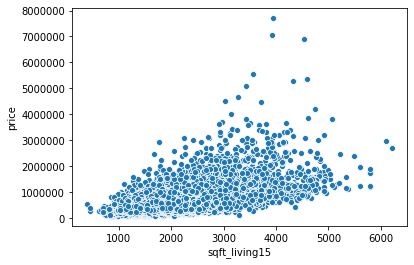

In [18]:
# scatterplot of average living space of 15 nearest properties to selected property and price
sns.scatterplot(df.sqft_living15, df.price)

C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


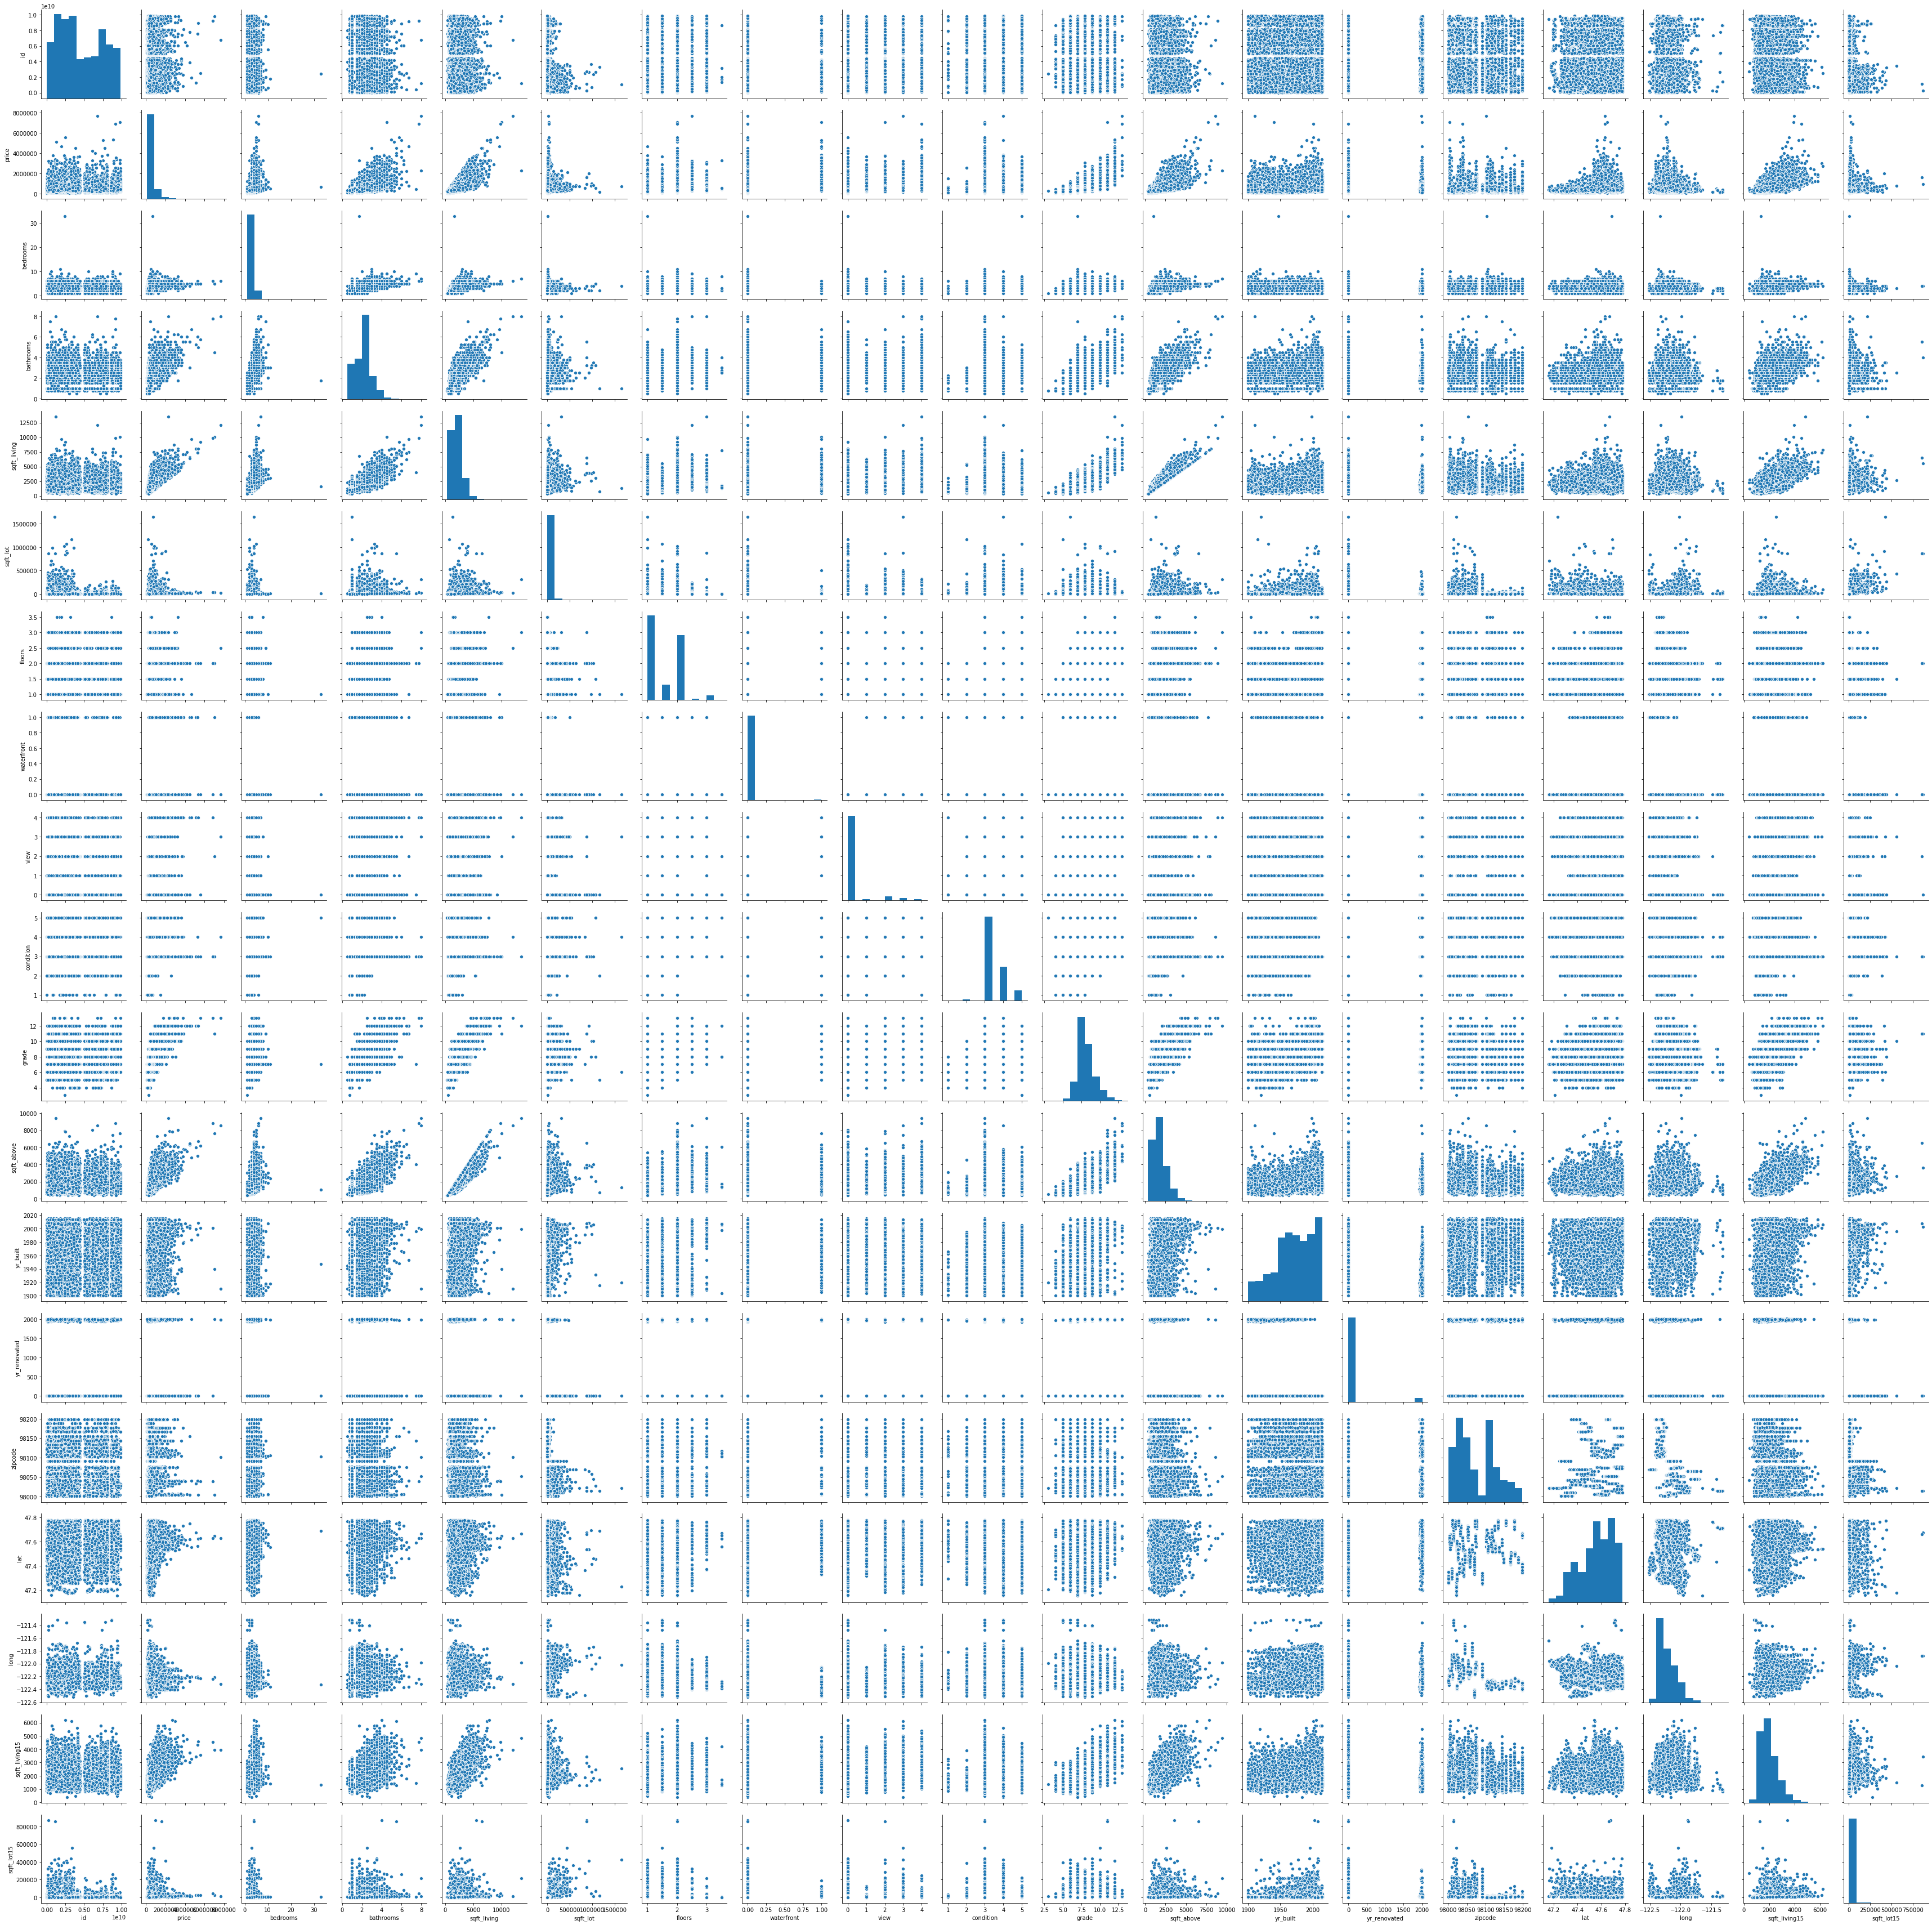

In [19]:
sns.pairplot(df)

### Finding Data Most Correlated to Price

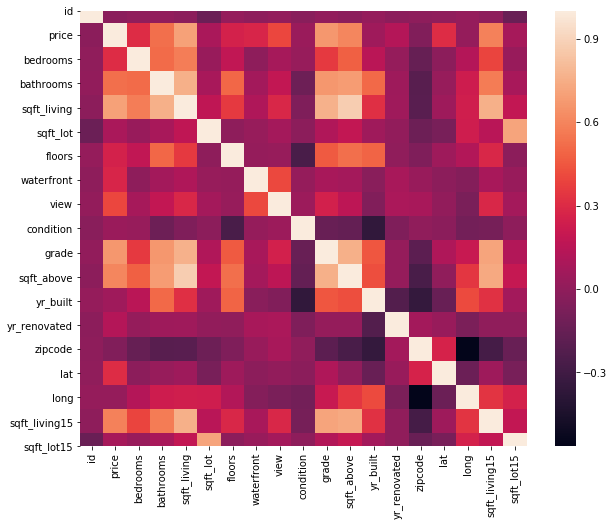

In [37]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr())

In [80]:
# adding an age of home category to dataframe
df_age = df.yr_built.apply(lambda x: 2020-x)

In [81]:
df_age

0        65
1        69
2        87
3        55
4        33
         ..
21592    11
21593     6
21594    11
21595    16
21596    12
Name: yr_built, Length: 21597, dtype: int64

In [84]:
df['age']=df_age

In [85]:
# Looking at statistics for dataframe
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,49.000324
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950,29.375234
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,5.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,23.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,45.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,69.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,120.000000


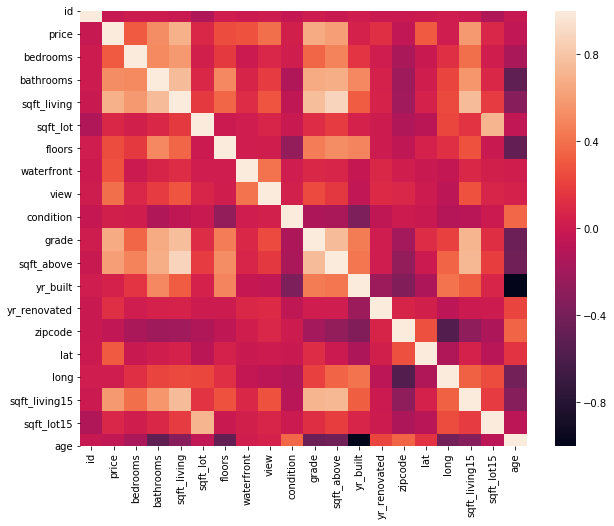

In [86]:
# Correlation heatmap to see if age of home is correlated to price
plt.figure(figsize=(10,8))
sns.heatmap(df.corr())

## What range do most prices fall within?

(array([   0.,   24.,  146.,  613., 1514., 2131., 2186., 2067., 1998.,
        1715., 1494., 1345., 1042.,  912.,  744.,  666.,  504.,  463.]),
 array([     0,  50000, 100000, 150000, 200000, 250000, 300000, 350000,
        400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000,
        800000, 850000, 900000]),
 <a list of 18 Patch objects>)

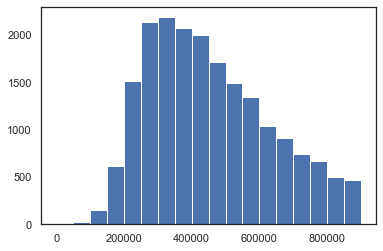

In [182]:
# histogram for house prices
plt.hist(df.price,[0,50000,100000,150000,200000,250000,300000,350000,400000,450000,500000,550000,600000,650000,700000,750000,800000,
                  850000,900000])

In [87]:
# correlation matrix for parameters
sns.set(style='white')
corr=df.corr()
corr

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557,-0.021617
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845,-0.053953
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.155670
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303,-0.507173
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342,-0.318152
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204,-0.052946
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722,-0.489193
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002,0.026079
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332,0.054564
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126,0.361592


In [35]:
# y dataframe is prices
y=df.price

In [119]:
# picking features 
df_features=["bedrooms","bathrooms","sqft_living","sqft_lot","floors",
             "condition","grade","sqft_above","yr_built",
             "zipcode","lat","long","sqft_living15","sqft_lot15"]

In [120]:
# X dataframe is relevant features
X=df[df_features]

In [121]:
X.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,3.409825,7.657915,1788.596842,1970.999676,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.650546,1.173200,827.759761,29.375234,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,3.000000,370.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [122]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,3,7,1180,1955,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,3,7,2170,1951,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,3,6,770,1933,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,5,7,1050,1965,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,3,8,1680,1987,98074,47.6168,-122.045,1800,7503


## Decision Tree Model

In [123]:
# import DecisionTreeModel
from sklearn.tree import DecisionTreeRegressor

df_model= DecisionTreeRegressor(random_state=1)
# training data
df_model.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [124]:
print(df_model.predict(X.head(5)))

[221900. 538000. 180000. 604000. 510000.]


In [125]:
print(y.head(5))

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64


In [126]:
# Predicting in-sample scores
from sklearn.metrics import mean_absolute_error

predicted_home_prices = df_model.predict(X)
mean_absolute_error(y, predicted_home_prices)

1126.5498448858639

In [127]:
'''split data into training and validation data, for both features and target
The split is based on a random number generator. Supplying a numeric value to
the random_state argument guarantees we get the same split every time we
run this script.'''
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
# Define model
df_model = DecisionTreeRegressor()
# Fit model
df_model.fit(train_X, train_y)

# get predicted prices on validation data
val_predictions = df_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

103663.41342592593


In [128]:
# function to compare mean absolute error scores for different numbers of leaf nodes
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [129]:
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  153894
Max leaf nodes: 50  		 Mean Absolute Error:  105487
Max leaf nodes: 500  		 Mean Absolute Error:  92483
Max leaf nodes: 5000  		 Mean Absolute Error:  101076


Decision tree with 500 nodes has the lowest MAE

## Random Forest Regressor

In [130]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
df_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, df_preds))

C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


75443.37301675485


Mean absolute error is 75,443 using Random Forest Regressor

## XGB Regressor

In [147]:
# imports
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold 
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import xgboost

In [148]:
X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,3,7,1180,1955,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,3,7,2170,1951,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,3,6,770,1933,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,5,7,1050,1965,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,3,8,1680,1987,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,1131,3.0,3,8,1530,2009,98103,47.6993,-122.346,1530,1509
21593,4,2.50,2310,5813,2.0,3,8,2310,2014,98146,47.5107,-122.362,1830,7200
21594,2,0.75,1020,1350,2.0,3,7,1020,2009,98144,47.5944,-122.299,1020,2007
21595,3,2.50,1600,2388,2.0,3,8,1600,2004,98027,47.5345,-122.069,1410,1287


In [149]:
# base model linear regression
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=.33,random_state=42)

regr=linear_model.LinearRegression()

regr.fit(X_train,y_train)

y_pred=regr.predict(X_test)

print(regr.coef_)

[-4.78386248e+04  5.03510027e+04  1.81408185e+02  1.09432740e-01
  1.73895861e+04  2.76817125e+04  1.06128296e+05 -5.64542963e+00
 -3.14582906e+03 -4.63669571e+02  5.29908232e+05 -2.37326486e+05
  4.69571524e+01 -3.86096811e-01]


In [150]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

131028.86944134465
45287178178.295364
212807.8433194965
0.653601551728758


R-squared using XGBoost is 0.65, however the mean squared error is very high.

## Decision Tree Regressor R-squared and Errors 

In [151]:
regr_1 = DecisionTreeRegressor(max_depth=df.shape[0]-1)
regr_1.fit(X_train, y_train)
y_1 = regr_1.predict(X_test)

In [152]:
print('Mean Absolute Error',metrics.mean_absolute_error(y_test, y_1))
print('Mean Squared Error',metrics.mean_squared_error(y_test, y_1))
print('Root Mean Squared Error',np.sqrt(metrics.mean_squared_error(y_test, y_1)))
print('R-squared',r2_score(y_test, y_1))

Mean Absolute Error 103615.11062008979
Mean Squared Error 36799812157.46994
Root Mean Squared Error 191832.77133344536
R-squared 0.7185208188985779


These models did not turn out as well as the models in other notebooks, so they were not used in the final analysis.